# Assignment 1: Deadline: first class in week 4 of the course: 25-2-2025 10:00 (if updated).
Hand in this notebook with output. Make sure that it is able to run and produce all the figures and results you show. Also, use the text boxes to answer the questions and interpret your results, relating them to the course materials.


Exercises made by Oliver Gurney-Champion. Please contact us via Canvas, or e-mail directly to:
Oliver: o.j.gurney-champion@amsterdamumc.nl
Matthan: m.w.a.caan@amsterdamumc.nl
Dilara: d.tank@amsterdamumc.nl
Daan: d.kuppens@amsterdamumc.nl

These are a large set of challenging exercises, for which you will get 3 weeks to complete. I would strongly advise you to stick to the suggested schedule, which will ensure you have sufficient knowledge to answer the questions when completing them, and finalize all questions in time.

Note that the networks will be lite and can run on your local computer/laptop in short time (minutes). There is no need as yet to run this on Surf, although we highly encourage you to make sure Surf works for you (for exercise sets 2 and 3).

# Exercise 1: Program network in PyTorch. (60%)
During the class, a brief introduction was given to quantitative imaging. In this exercise, you will program your first neural network that will help estimate quantitative MRI parameters from quantitative data. In particular, we will be looking at the intra-voxel incoherent motion (IVIM) model for diffusion-weighted MRI:

S(b)=S_0×( (1-f)×e^-b×D^ +f×e^-b×D*^ )                                                                    [1]

With S the measured signal, S0 the baseline signal at S(b=0), f the perfusion fraction, D the diffusion coefficient and D* the pseudo diffusion coefficient. For more information on what the model means exactly and how it is used clinically, I would suggest reading "Introduction to IVIM MRI | Radiology Key" (https://radiologykey.com/introduction-to-ivim-mri/). But for the purpose of this exercise, it is just a model.

Normally, f, D and D* (named Dp in the code) are obtained by fitting S(b) using least-squares fitting. But these approaches are known to be prone to noise in the data and often produce poor estimates.

Therefore, you will write a neural network that predicts f from a given S(b). There are great tools available that take care of training models, such as PyTorch, Karas and Tensorflow. However, for the purpose of this exercise, you will make use of PyTorch. Moreover, we will use weights-and-biasses to keep track of how training is going.

# Wednesday 3-4-2024
At https://github.com/oliverchampion/AI_for_medical_imaging_course you will find the Python assignment. To help visualize progress and to isolate certain snippets of code, we wrote this as a Jupyter Notebook (exercise1.ipynb). As you can see, we have already provided a data-generator, some plotting tools to plot the training progress. The notebook should run as is and train a neural network! For your first lecture, we suggest you (Wednesday)
-	Install all prerequisites in your virtual enviroment (requierements.txt)
-	Start a WandB account @ https://wandb.ai/  you will need to log in when running the script
-	Go through the script to see whether you understand what happens.
-	Train your first neural network .
-	Visualize the results on your WandB page.

## Import requiered packages
imports the packages and sets the random seed

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np
import helper_functions as hf
import torch
import os
import torch.nn as nn
from matplotlib import pyplot as plt

# set random seed
seed =42

login to your free wandb account. Note you will need to set up your account on https://wandb.ai/authorize
wandb allows you to keep track of your neural network training.

In [2]:
import wandb
os.environ["WANDB_SILENT"] = "true"
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


True

## Simulate and view the IVIM data
This allows you to study what the data looks like in jupyter.

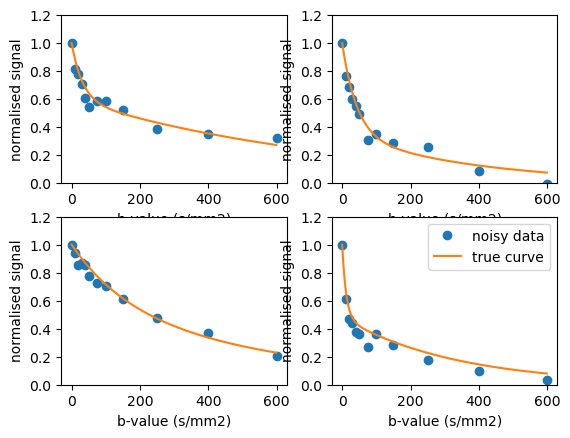

In [3]:
# set b-values at which we "measure" (i.e. simulate signal)
bvalues=[0, 10, 20, 30, 40, 50, 75, 100, 150, 250, 400, 600]

## Set the random seeds for reproducibility
np.random.seed(seed)
random.seed(seed)

## Loading the (simulated) dataset
data_sim, D, f, Dp = hf.sim_signal(SNR=(10,30),bvalues=bvalues,sims=30,seed=np.random.randint(1,10000))

## plotting some curves and data for visualisation
fig, axs = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        axs[i, j].plot(bvalues, data_sim[i+10*j,:], 'o')
        datapred=hf.ivim(np.arange(0,np.max(bvalues)), D[i+10*j], f[i+10*j], Dp[i+10*j], 1)
        axs[i, j].plot(np.arange(0,np.max(bvalues)), datapred)
        axs[i, j].set_ylim(0, 1.2)
        axs[i, j].set(xlabel='b-value (s/mm2)', ylabel='normalised signal')
plt.legend(('noisy data', 'true curve'))

## Splitting the data into training and validation
Here, we split our data into a training set, validation set and test set. Note that the current implementation only uses the training set and it is up to you (in your exercises) to also implement the validation and test run. At this point, we already split the data for you.

In [4]:
def sim_dat(bvalues,batch_size = 16,SNR=(10,40),sims=1000,seed=np.random.randint(1,10000)):
    with wandb.init(project="AI_for_medical_imaging", job_type="visualize data") as run:
        data_sim = hf.sim_signal(SNR=SNR,bvalues=bvalues,sims=sims,seed=seed)
        # Only for visualisation purposes: here we create our "Artifact" in wandb --> this allows viewing the data in your wandb account
        for i in range(4):
            #make b-value data pairs
            example_data=[[x,y] for (x,y) in zip(bvalues,data_sim[0][i])]
            # put it in a table
            table = wandb.Table(data=example_data, columns=["b-values", "signal"])
            #tell wandb to plot the table
            wandb.log({"data_plot " + str(i): wandb.plot.scatter(table, "b-values", "signal")})

        # here we split the data into train (70%), test (15%) and validation (15%) sets
        #split = int(np.floor(len(data_sim[0]) * 0.7))
        train_set, test_set, val_set = torch.utils.data.random_split([[data_sim[0][i,:],data_sim[1][i],data_sim[2][i],data_sim[3][i]] for i in range(len(data_sim[3]))],[0.7,0.15,0.15])
        #split = int(np.floor(len(rest) * 0.5))
        #test_set, val_set = torch.utils.data.random_split([[rest[0][i,:],rest[1][i],rest[2][i],rest[3][i]] for i in range(len(rest[3]))],[split, len(rest[0]) - split])

        # train loader loads the trianing data. We want to shuffle to make sure data order is modified each epoch and different data is selected each epoch.
        trainloader = torch.utils.data.DataLoader(train_set,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       drop_last=True)
        # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        inferloader = torch.utils.data.DataLoader(val_set,
                                       batch_size=min(batch_size,len(val_set)),
                                       shuffle=False,
                                       drop_last=False)#was False initially, changed it to True for i,j
            # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        testloader = torch.utils.data.DataLoader(test_set,
                                       batch_size=min(batch_size,len(test_set)),
                                       shuffle=False,
                                       drop_last=False)
    return trainloader, inferloader, testloader
sim_dat(bvalues)

(<torch.utils.data.dataloader.DataLoader at 0x177984800>,
 <torch.utils.data.dataloader.DataLoader at 0x30c6e9040>)

## Design a neural network

In [5]:
class CustomOutputLayer(nn.Module):
    def __init__(self):
        super(CustomOutputLayer, self).__init__()

    def forward(self, x):
        # Sigmoid activation to constrain outputs within (0,1)
        x = torch.sigmoid(x)

        # Scale the outputs to the desired ranges
        f_pred = x[:, 0] * (1 - 0) + 0    # f in (0,1)
        D_pred = x[:, 1] * (3.5e-3 - 0.5e-3) + 0.5e-3  # D in (0.5e-3, 3.5e-3)
        Dp_pred = x[:, 2] * (130e-3 - 5e-3) + 5e-3  # D* in (5e-3, 130e-3)

        return torch.stack([f_pred, D_pred, Dp_pred], dim=1)
# funtion for stacking the layers and making the model
def make_model(n_inputs=5,n_hidden=1,n_outputs=1, n_width=5, function="ReLU", custom_output=0):
    #initialize the model object
    model = nn.Sequential()
    model.add_module('layer_linear0', nn.Linear(n_inputs, n_width))
    if function == 'ReLU':
       model.add_module('layer_ReLu0', nn.ReLU())
    elif function == 'Sigmoid':
        model.add_module('layer_Sigmoid0', nn.Sigmoid()) 
    elif function == 'ELU':
        model.add_module('layer_ELU0', nn.ELU())
    elif function == 'Tanh':
        model.add_module('layer_Tanh0', nn.Tanh())

        # fill out the model with hidden layers.
    for i in range(1, n_hidden):
        # as we loop, we add hidden layers
        model.add_module('layer_linear'+str(i), nn.Linear(n_width, n_width))
        # we also add a ReLu layer
        if function == 'ReLU':
            model.add_module('layer_ReLu'+str(i), nn.ReLU())
        elif function == 'Sigmoid':
            model.add_module('layer_Sigmoid'+str(i), nn.Sigmoid())
        elif function == 'ELU':
            model.add_module('layer_ELU'+str(i), nn.ELU())
        elif function == 'Tanh':
            model.add_module('layer_Tanh'+str(i), nn.Tanh())
    #and a final output layer
    model.add_module('last_layer',nn.Linear(n_width, n_outputs))
    #scale output
    if custom_output == 1:
        model.add_module('last_custom', CustomOutputLayer())
    elif custom_output == 0:
        model.add_module('last',nn.Sigmoid())
    model.apply(init_weights)

    return model

# function for initializing network weights for individual layers
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

train your first network

In [6]:
def train_network(name, epochs=200, learningrate=0.1, hidden_layers=2, seed=42, optimizer='SGD',bvalues=bvalues,batch_size=16,sims=1000):

    trainloader, inferloader, testloader = sim_dat(bvalues,batch_size=batch_size,sims=sims)

    model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, n_outputs=1)

    # initialize model --> we did this above, but during the exercise, you might be re-running this part of the script several times with different settings. This way we make sure you re-initiate the training and don't continue in the last model
    model.apply(init_weights)

    # initialize wandb
    wandb.init(
            project="AI_for_medical_imaging", job_type="training", name=name)

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False

    # Set default device. If GPU is available, the network will be trained on the GPU. Note that further down in the code, stuff will be sent ".to(device)" to make sure it is available on the GPU.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # the optimizer determines how strongly to update the network's weights based on the calculated loss.
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')

    # loop over epochs
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f = 0
        val_loss_f = 0
        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()
        #loop over all training data0
        SD_train = 0
        sys_train = 0
        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            batch=x[0].to(device)
            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            # put the data through the neural network
            f_pred = torch.flatten(model.forward(batch))
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            #add found loss to the train loss, to keep track of the loss this epoch
            train_loss_f += loss_f.item()
            # propogate the loss through the network (calculate d_wights/d_loss)
            loss_f.backward()
            # update all weights accoording to their derrivatives to the loss.
            optimizer.step()
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the trianing data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train += SD**2
            sys_train += sys
        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()
        # after training, set model to evaluation mode
        model.eval()
        # initialize error_metrics
        SD_val=0
        sys_val=0
        ######################your code here for validation loss#########################
        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        # put it in a table
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        #tell wandb to plot the table
        # note that some parameters are being logged which you still need to define in the validation loop!
        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})

        ## print output in terminal. Only useful for debugging when WandB does not work
        #print('epoch = ' + str(epoch) + ' train loss =' + str(train_loss_f/trainloader.__len__()) +' val loss =' + str(val_loss_f/inferloader.__len__()) + 'the systematic error is ' + str(sys_val) + ' and the random error is ' + str(SD_val))
    wandb.finish()
    #return val_test SD_test

train_network('test')

# First week (on schedule means finish by Friday) [if updated: 7-2-2025]
For these exercises, you will want to produce new cells that generate the outputs. The notebook cells should run and produce the figures without input of the examiners.

## 1A-C: train the neural network
Adapt the script above for your exercises A-C such that it produces the desired results and plots. Describe the results/intepertation in this text baloon.

A.	The current network implementation only looks at training data. This means that the network’s performance is over-estimated. Please use the validation set to monitor performance during training (note that we have already put the model on evaluation mode in line 59). At what point is the network fully trained? Explain how you know this. Show the effect from overfitting and underfitting.<br>

In general, the validation loss typically decreases as the model learns the patterns of the data better. An indication of a fully trained model can be that both the training and validation losses are low. Additionally, if the validation loss of the model does not improve for several epochs, it is likely that the model has reached its optimal learning point. In this case we are also using the MSE as a metric to monitor the model's performance. Once the MSE stops improving over several epochs, it is another indication that the model is fully trained.
Regarding the effect of over- and underfitting, a model can be considered to overfit to data when the difference between the training and validation loss is large even after many epochs. 
SAY SOMETHING ABOUT THE UNDER/OVERFITTING PLOTS

- zoe writes something

B.	Similarly, use the test dataset to test for final performance. Explain why this is needed.<br>

In order to understand how a trained model performs in a setting that is closer to resembling real-life, it is necessary to test its performance on unseen data. The training and validation data helps the model learn about underlying patterns and fine-tunes hyperparameters, whereas the test data is a saparate process to measure how well the model does on real-world data. Using a test set is necessary to ensure that the model is unbiased, and/or does not overfit to the training data. It is also a way to test the robustness of the model to variations, edge-cases and/or noisy data. 

C.	Currently, standard gradient descent optimizer is being used to train the network, with a learning rate of 0.01. Investigate the performance of the network for different  optimizer (i.e. adam loss was discussed in the lecture) and explain what you see. What does the Adam  optimizer do differently from the SGD  optimizer that would make it perform better/differently?

In the table below, te results of the four different optimizers are presented. Here, it can be noted that the losses of SGD and Adam show very minimal differences. Considering the approach that both optimizers take, SGD is better at generalizing larger datasets and converges smoother whereas Adam, even though it adapts well to gradients may overfit and perform worse on larger datasets. These issues could be at the cause of the slightly better peformance of SGD. To improve the performance of Adam, it would be possible to add regularization. As Adam can overfit to training data, regularization techniques such as L2 or Dropout can improve generalization.
The RMSprop performs the worst out of all four considered optimizers, likely due to an unsuitable learning rate for this task. It is an optimizer that is more fit for RNNs and NLPs, thus, will struggle more with simpler optimization landscapes. Additionally, RMSprop is sensitive to hyperparamter tuning, thus, the default settings used in this exercise might not work optimally.
Adagrad on the other hand seems to perform the best out of all four optimizers. Adagrad automatically adjusts the learning rate for each parameter, making it more robust to the learning rate choice. 




Code for 1A

In [6]:
#function that creates the model, splits the data and initializes the optimizer
def create_data_model(name, learningrate=0.1, hidden_layers=2, seed=42, optimizer='SGD',bvalues=bvalues,batch_size=16,sims=1000, n_width=len(bvalues), function_act="ReLU", n_outputs=1, custom_output=0):
    trainloader, inferloader, testloader = sim_dat(bvalues,batch_size=batch_size,sims=sims) 

    # initialize model
    model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, n_outputs=n_outputs, n_width=n_width, function=function_act, custom_output=custom_output)
    model.apply(init_weights)

    # initialize wandb
    wandb.init(
            project="AI_for_medical_imaging", job_type="training", name=name)

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False

    # Set default device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # define the optimizers
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    elif optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learningrate)
    elif optimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learningrate)
    elif optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learningrate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')
    return model, trainloader, inferloader, testloader, loss_module, device, optimizer

In [7]:
#function that trains the model and logs the results, including the loss and the error metrics
def train_val_network(model, trainloader, inferloader, testloader, loss_module, device, optimizer, epochs=200):
    
    train_losses = []
    val_losses = []
    val_sys_errors = []
    val_SD_errors = []
    train_sys_errors = []
    train_SD_errors = []
   
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f = 0
        val_loss_f = 0
        
        # set model to training mode
        model.train()
        
        #loop over all training data
        SD_train = 0
        sys_train = 0

        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data and put on device
            batch=x[0].to(device)
            f_ref = torch.flatten(x[2].to(device))
            
            # put the data through the neural network
            f_pred = torch.flatten(model.forward(batch))
            
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            train_loss_f += loss_f.item()
            
            # propogate the loss through the network (calculate d_wights/d_loss)
            loss_f.backward()
            optimizer.step()
            
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            SD_train += SD**2
            sys_train += sys
        
        # calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()
        train_sys_errors.append(sys_train)
        train_SD_errors.append(SD_train)

        # set model to evaluation mode
        model.eval()
        
        # loop over validation data
        SD_val=0
        sys_val=0
        ######################your code here for validation loss#########################
        for x in inferloader:
            # get data and put on devide
            batch=x[0].to(device)
            f_ref_val = torch.flatten(x[2].to(device))
            
            # put the data through the neural network
            f_pred_val = torch.flatten(model.forward(batch))
            
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred_val, f_ref_val)
            val_loss_f += loss_f.item()
            
            # calculate the standard deviation and systematic error on the validation data
            SD, sys = hf.error_metrics(f_pred_val.cpu().detach().numpy(),f_ref_val.cpu().detach().numpy())
            SD_val += SD**2
            sys_val += sys
        
        # calculate the mean (sys error) and square of mean (SD).
        SD_val = np.sqrt(SD_val/inferloader.__len__())
        sys_val = sys_val/inferloader.__len__()

        # append all losses to the lists
        train_losses.append(train_loss_f/trainloader.__len__())
        val_losses.append(val_loss_f/inferloader.__len__())
        val_sys_errors.append(sys_val)
        val_SD_errors.append(SD_val)

        # Log training and validation loss
        wandb.log({
            "loss/train": train_losses[-1],
            "loss/val": val_losses[-1],
            "error/random error": SD_train,
            "error/systematic error": sys_train
        })

        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data.
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        example_data_val=[[x,y] for (x,y) in zip(f_ref_val.cpu().detach().numpy(),f_pred_val.cpu().detach().numpy())]
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        table_val = wandb.Table(data=example_data_val, columns=["f_ref_val", "f_pred_val"])

        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            wandb.log({"data_plot_val epoch " + str(epoch): wandb.plot.scatter(table_val, "f_ref_val", "f_pred_val", title=f'epoch{epoch}')})
        
        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        example_data_val=[[x,y] for (x,y) in zip(f_ref_val.cpu().detach().numpy(),f_pred_val.cpu().detach().numpy())]
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        table_val = wandb.Table(data=example_data_val, columns=["f_ref_val", "f_pred_val"])

        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            wandb.log({"data_plot_val epoch " + str(epoch): wandb.plot.scatter(table_val, "f_ref_val", "f_pred_val", title=f'epoch{epoch}')})


    return train_losses, val_losses, val_sys_errors, val_SD_errors, train_sys_errors, train_SD_errors

Answer B

In [8]:
def test_network(model, trainloader, inferloader, testloader, device, loss_module):

    # set model to evaluation mode
    model.eval()
    
    test_loss_f = 0
    f_ref_test_list = []
    f_pred_test_list = []
    SD_test = 0
    sys_test = 0
    
    with torch.no_grad():
        for x in testloader:
            # get data and put on devide
            batch=x[0].to(device)
            f_ref_test = torch.flatten(x[2].to(device))
            
            # put the data through the neural network
            f_pred_test = torch.flatten(model.forward(batch))
            
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred_test, f_ref_test)
            
            # append loss to the lists
            test_loss_f += loss_f.item()
            f_ref_test_list.append(f_ref_test)
            f_pred_test_list.append(f_pred_test)
            
            # calculate SD and system error
            SD, sys = hf.error_metrics(f_pred_test.cpu().detach().numpy(),f_ref_test.cpu().detach().numpy())
            SD_test += SD**2
            sys_test += sys
        
        # calculate MSE
        SD_test = np.sqrt(SD_test/testloader.__len__())
        sys_test = sys_test/testloader.__len__()

            
    test_loss_f /= len(testloader)
    
    
    return f_ref_test_list, f_pred_test_list, test_loss_f, SD_test, sys_test
    

ReLU


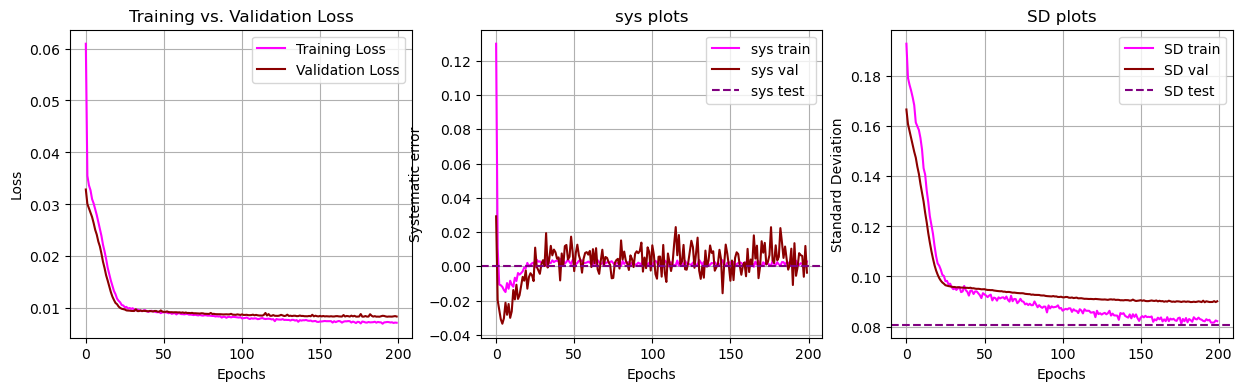

Final Test Loss: 0.006740641710348427
Final Validation Loss: 0.008421998948324471
Final Training Loss: 0.007222943744340608


In [12]:
model, trainloader, inferloader, testloader, loss_module, device, optimizer = create_data_model('test')
train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, optimizer, epochs=200)

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Plot training vs. validation loss
axes[0].plot(range(len(train_losses)), train_losses, label="Training Loss", color="magenta")
axes[0].plot(range(len(val_losses)), val_losses, label="Validation Loss", color="darkred")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training vs. Validation Loss")
axes[0].grid(True)
axes[0].legend()

f_ref_test, f_pred_test, test_loss_f, SD_test, sys_test = test_network(model, trainloader, inferloader, testloader, device, loss_module)
f_ref_test = torch.cat(f_ref_test).cpu().detach().numpy()
f_pred_test = torch.cat(f_pred_test).cpu().detach().numpy()



# Plot the results
axes[1].plot(range(len(train_losses)), sys_train, color="magenta", label="sys train")
axes[1].plot(range(len(val_losses)), sys_val, color="darkred", label="sys val")
axes[1].axhline(sys_test, color="purple", label="sys test", linestyle = "--")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Systematic error")
axes[1].set_title("sys plots")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(range(len(train_losses)), SD_train, color="magenta", label="SD train")
axes[2].plot(range(len(val_losses)), SD_val, color="darkred", label="SD val")
axes[2].axhline(SD_test, color="purple", label="SD test", linestyle = "--")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Standard Deviation")
axes[2].set_title("SD plots")
axes[2].legend()
axes[2].grid(True)
plt.show()

print(f"Final Test Loss: {test_loss_f}")
print(f"Final Validation Loss: {val_losses[-1]}")
print(f"Final Training Loss: {train_losses[-1]}")


Answer C

In [52]:
import pandas as pd

#run all of the above for different optimizers, show results in table
optimizers = ["SGD", "Adam", "RMSprop", "Adagrad"]
results = {}
sys_test = []
SD_test = []
for optimizer in optimizers:
    model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer=optimizer)
    train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=200)
    f_ref_test, f_pred_test, test_loss_f, SD_test, sys_test = test_network(model, trainloader, inferloader, testloader, device, loss_module)
    f_ref_test = torch.cat(f_ref_test).cpu().detach().numpy()
    f_pred_test = torch.cat(f_pred_test).cpu().detach().numpy()
    results[optimizer] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "Final Train Loss": train_losses[-1],
        "Final Validation Loss": val_losses[-1],
        "f_ref_test": f_ref_test,
        "f_pred_test": f_pred_test,
        "Final Test Loss": test_loss_f
    }

# Convert results to DataFrame for easier visualization
df_results = pd.DataFrame.from_dict(results, orient='index', columns=["Final Train Loss", "Final Validation Loss", "Final Test Loss"])

# Display table
print(df_results)



         Final Train Loss  Final Validation Loss  Final Test Loss
SGD              0.007223               0.008422         0.006741
Adam             0.007787               0.008877         0.006934
RMSprop          0.461651               0.432921         0.459410
Adagrad          0.006697               0.008154         0.006641


D.	Return back to SGD. Test how the performance depends on the learning rate. This can be done by plotting the systematic (sys_test) and random (SD_test) errors as function of learning rate (10<LR<0.0000001; steps in order of magnitude; e.g. 10, 1, 0.1, ….).
Plot the performance (sys_val and SD_val) as function of the learning rate and add this to your report. Explain what you see (hint: take a look at the loss curves). Easiest is to save the final performance and plot it in the jupyter notebook.

#### Evaluating the plots for D:

The plots show the relationship between learning rate and model performance (test loss, systematic error, and random error). At very small learning rates (10^−6), the model struggles to converge, leading to high test loss and errors. As the learning rate increases (10^−4 to 10^−2), the model converges more effectively, resulting in lower test loss and reduced systematic and random errors. The best performance appears in this intermediate range, where errors are minimized, and the test loss is at its lowest.
At very high learning rates (10^0 =1 and above), the model diverges or becomes unstable, resulting in an increase in errors and test loss. This is because the large steps prevent the model from finding the optimal solution, overshooting the minima. The validation metrics follow a similar trend, indicating consistent generalization across training, validation, and testing. Overall, the results highlight the importance of choosing an appropriate learning rate for optimal model performance.

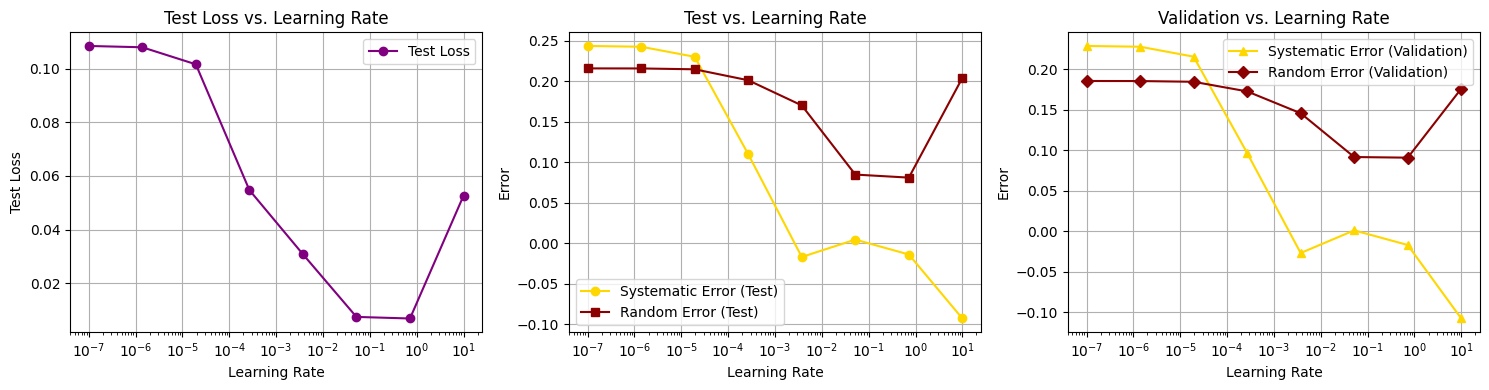

In [53]:
learning_rates = np.logspace(start= -7, stop = 1, num = 8, base  = 10)
results = {}

for learning_rate in learning_rates:
    model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="SGD", learningrate=learning_rate)
    
    train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=200)
    
    f_ref_test, f_pred_test, test_loss_f, SD_test, sys_test = test_network(model, trainloader, inferloader, testloader, device, loss_module)
    
    f_ref_test = torch.cat(f_ref_test).cpu().detach().numpy()
    f_pred_test = torch.cat(f_pred_test).cpu().detach().numpy()

    results[learning_rate] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "Final Train Loss": train_losses[-1],
        "Final Validation Loss": val_losses[-1],
        "f_ref_test": f_ref_test,
        "f_pred_test": f_pred_test,
        "Final Test Loss": test_loss_f,
        "sys test": sys_test,
        "SD test": SD_test,
        "sys val": sys_val[-1],
        "SD val": SD_val[-1]
    }

    
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Plot 1: Test Loss vs. Learning Rate
axes[0].semilogx(learning_rates, [results[lr]["Final Test Loss"] for lr in learning_rates], marker='o', label="Test Loss", color = "purple")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Test Loss")
axes[0].set_title("Test Loss vs. Learning Rate")
axes[0].grid(True)
axes[0].legend()

# Plot 2: Systematic and Random Errors on Test Set vs. Learning Rate
axes[1].semilogx(learning_rates, [results[lr]["sys test"] for lr in learning_rates], marker='o', label="Systematic Error (Test)", color = "gold")
axes[1].semilogx(learning_rates, [results[lr]["SD test"] for lr in learning_rates], marker='s', label="Random Error (Test)", color = "darkred")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Error")
axes[1].set_title("Test vs. Learning Rate")
axes[1].grid(True)
axes[1].legend()

# Plot 3: Systematic and Random Errors on Validation Set vs. Learning Rate
axes[2].semilogx(learning_rates, [results[lr]["sys val"] for lr in learning_rates], marker='^', label="Systematic Error (Validation)", color = "gold")
axes[2].semilogx(learning_rates, [results[lr]["SD val"] for lr in learning_rates], marker='D', label="Random Error (Validation)", color = "darkred")
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Error")
axes[2].set_title("Validation vs. Learning Rate")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()


E.	Plot the performance (sys_val and SD_val) as function of the width (number of neurons per layer: 5, 10, 20, 50, 100) and depth (number of hidden layers: 1, 2, ..., 8) of the network and add these to the report. Discuss how width and depth may influence the network; if it has this behaviour in your data, highlight it; if not, explain why it may not occur in your dataset.

Hint: currently, the width of the network copies the width of the data, so you need to uncouple the input width from the network width by adapting the "make model" code.
Tip: you only need to plot different widths for 1 depth (e.g. 2) and different depths for 1 width (e.g. 10).
Tip: possibly some effects get clearer when more training data is simulated ("sims" in data_sim). But also note that having too much training data may hide some of the effects from other exercises, so don't forget to revert it.

#### Evaluation of plots for E:
Validation Error vs. Width
- Systematic Error (gold curve): Increases slightly as the width of the network (number of neurons per layer) grows. This may indicate that the model is slightly overfitting when it has too many parameters and is unable to generalize effectively.
- Random Error (darkred curve): Remains mostly stable, with a slight decrease initially as width increases from 5 to 10 neurons. This suggests that adding more neurons has a diminishing return on reducing random error after a certain point.
- Increasing width has minimal impact on random error after an initial improvement. Increasing the width might slightly increase the systematic error due to overfitting.

Validation Error vs. Depth
- Systematic Error (gold curve): Stays relatively low and stable across different depths, except for a small increase at deeper networks. This indicates that increasing depth (number of hidden layers) may not significantly improve systematic error in this case.
- Random Error (darkred curve): Shows more fluctuation with increasing depth, suggesting that deeper networks are more sensitive to training noise or may struggle to learn effectively with the available data.

In general it seems that moderate widths and depths seem optimal for this dataset, as excessive complexity does not significantly improve performance and can increase error.

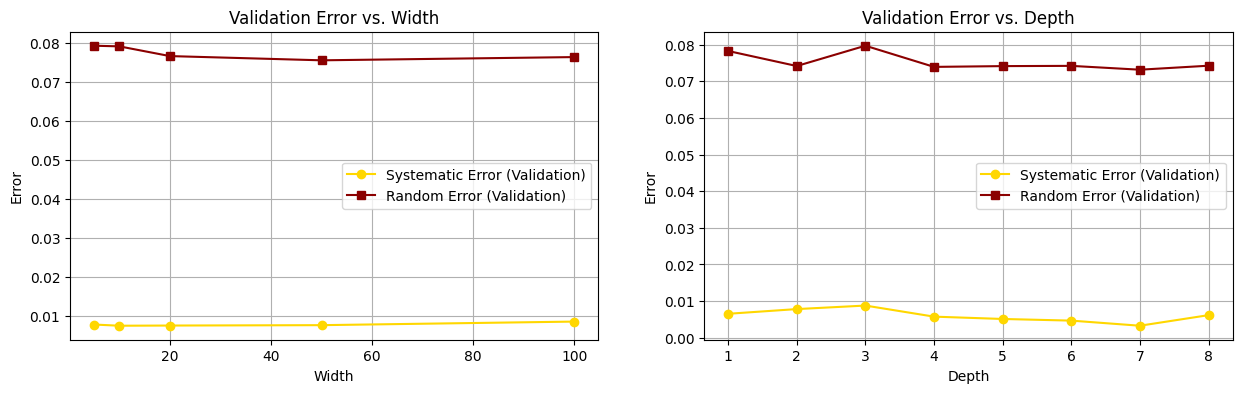

In [56]:
widths = [5, 10, 20, 50, 100]
depths = list(range(1, 9))

results_widths = {}
results_depths = {}

fix, axes = plt.subplots(1, 2, figsize=(15, 4))

for n_width in widths:
    model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="SGD", n_width=n_width, sims=2000)
    train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=200)
    results_widths[n_width]={
        "train_losses": train_losses,
        "val_losses": val_losses,
        "Final Train Loss": train_losses[-1],
        "Final Validation Loss": val_losses[-1],
        "sys val": sys_val[-1],
        "SD val": SD_val[-1]
    }
#plot sys_val and sd_val for different widths
axes[0].plot(widths, [results_widths[n]["sys val"] for n in widths], marker='o', label="Systematic Error (Validation)", color="gold")
axes[0].plot(widths, [results_widths[n]["SD val"] for n in widths], marker='s', label="Random Error (Validation)", color = "darkred")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Error")
axes[0].set_title("Validation Error vs. Width")
axes[0].grid(True)
axes[0].legend()

for n_depth in depths:
    model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="SGD", hidden_layers=n_depth, sims=2000)
    train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=200)
    results_depths[n_depth]={
        "train_losses": train_losses,
        "val_losses": val_losses,
        "Final Train Loss": train_losses[-1],
        "Final Validation Loss": val_losses[-1],
        "sys val": sys_val[-1],
        "SD val": SD_val[-1]
    }

#plot sys_val and sd_val for different depths
axes[1].plot(depths, [results_depths[n]["sys val"] for n in depths], marker='o', label="Systematic Error (Validation)", color = "gold")
axes[1].plot(depths, [results_depths[n]["SD val"] for n in depths], marker='s', label="Random Error (Validation)", color = "darkred")
axes[1].set_xlabel("Depth")
axes[1].set_ylabel("Error")
axes[1].set_title("Validation Error vs. Depth")
axes[1].grid(True)
axes[1].legend()
plt.show()

F.	Try different batch sizes (1, 4, 16, 64, 128, 516).Explain the behavior of the network you see.What is the effect of having smaller batches? And larger batches?

#### Evaluation for plots of F:

The results show that smaller batch sizes (e.g., 1, 4) lead to better generalization, with lower test and validation losses, as well as reduced systematic errors. Smaller batches introduce more noise in the gradient updates, which helps the model escape local minima and improves performance. However, as the batch size increases (e.g., 128, 516), the model's performance deteriorates, with higher test loss and random errors, especially in validation metrics. Larger batch sizes result in smoother and more stable gradient updates but can lead to poorer generalization, as they may settle into sharp minima that do not generalize well.

The training and validation loss curves indicate that smaller batches converge faster and achieve lower final loss values. Conversely, larger batch sizes converge more slowly and plateau at higher loss values, which reflects less effective optimization. Random error increases significantly with large batches, highlighting the difficulty in capturing fine-grained patterns in the data. This behavior aligns with the general observation that smaller batches are better for noisy optimization and generalization, while larger batches can lead to overfitting or suboptimal performance. Balancing batch size is critical to achieve both efficient training and good generalization.

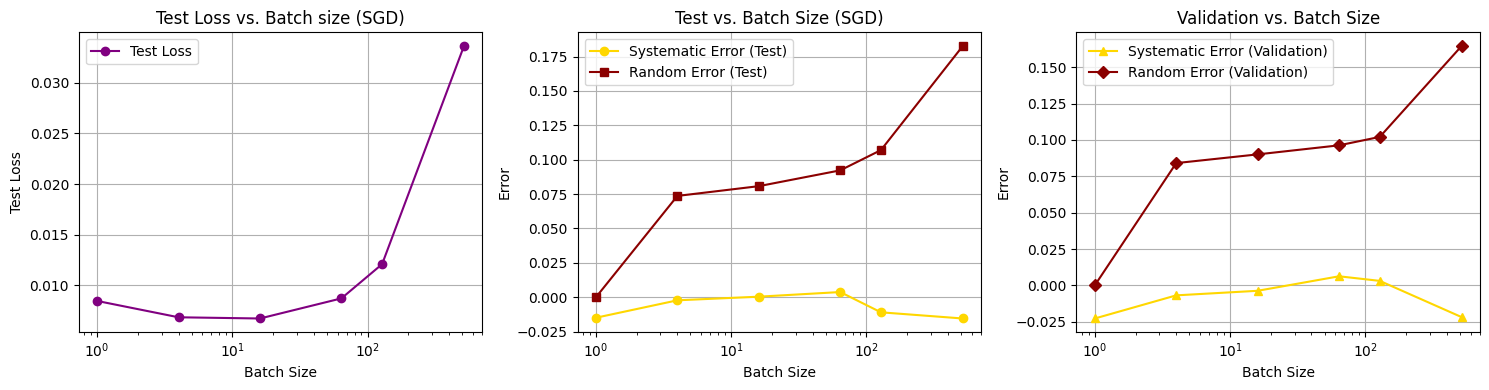

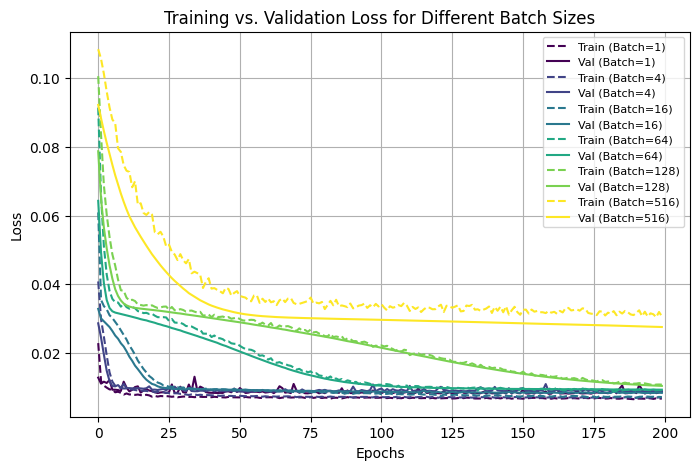

In [57]:
batch_sizes = [1, 4, 16, 64, 128, 516]
results = {}
for batch_size in batch_sizes:
    model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="SGD", batch_size=batch_size)
    
    train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=200)
    
    f_ref_test, f_pred_test, test_loss_f, SD_test, sys_test = test_network(model, trainloader, inferloader, testloader, device, loss_module)
    
    f_ref_test = torch.cat(f_ref_test).cpu().detach().numpy()
    f_pred_test = torch.cat(f_pred_test).cpu().detach().numpy()
    results[batch_size] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "Final Train Loss": train_losses[-1],
        "Final Validation Loss": val_losses[-1],
        "f_ref_test": f_ref_test,
        "f_pred_test": f_pred_test,
        "Final Test Loss": test_loss_f,
        "sys test": sys_test,
        "SD test": SD_test,
        "sys val": sys_val[-1],
        "SD val": SD_val[-1]
    }

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

#plot 1: test loss vs batch size
axes[0].semilogx(batch_sizes, [results[bs]["Final Test Loss"]for bs in batch_sizes], marker='o', label="Test Loss", color = "purple")
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Test Loss")
axes[0].set_title("Test Loss vs. Batch size (SGD)")
axes[0].grid(True)
axes[0].legend()

#plot 2: systematic and random errors on test set vs batch size
axes[1].semilogx(batch_sizes, [results[bs]["sys test"]for bs in batch_sizes], marker='o', label="Systematic Error (Test)", color = "gold")
axes[1].semilogx(batch_sizes, [results[bs]["SD test"]for bs in batch_sizes], marker='s', label="Random Error (Test)", color = "darkred")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Error")
axes[1].set_title("Test vs. Batch Size (SGD)")
axes[1].grid(True)
axes[1].legend()

#plot 3: systematic and random errors on validation set vs batch size
axes[2].semilogx(batch_sizes, [results[bs]["sys val"]for bs in batch_sizes], marker='^', label="Systematic Error (Validation)", color = "gold")
axes[2].semilogx(batch_sizes, [results[bs]["SD val"]for bs in batch_sizes], marker='D', label="Random Error (Validation)", color = "darkred")
axes[2].set_xlabel("Batch Size")
axes[2].set_ylabel("Error")
axes[2].set_title("Validation vs. Batch Size")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

#plot4: training vs validation loss
colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot training and validation loss for each batch size
for i, batch_size in enumerate(batch_sizes):
    epochs = range(len(results[batch_size]["train_losses"]))
    
    ax.plot(epochs, results[batch_size]["train_losses"], linestyle="--", color=colors[i], label=f"Train (Batch={batch_size})")
    ax.plot(epochs, results[batch_size]["val_losses"], linestyle="-", color=colors[i], label=f"Val (Batch={batch_size})")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training vs. Validation Loss for Different Batch Sizes")
ax.legend(loc="best", fontsize=8)  # Reduce font size for readability
ax.grid(True)

plt.show()


G. Choose 3 hidden layers, width of 40,  learning rate of 0.1 and batch size of 2. Now train the network for 3000 epochs. At what point in the network fully trained? How do you see this? Does any overfitting occur?

#### Evaluation of plot for G:
The training loss decreases consistently over the 3000 epochs, indicating that the model is learning and fitting the training data well. However, the validation loss plateaus early and exhibits noise, which suggests that the model stops improving on unseen data after a certain number of epochs. The divergence between training and validation losses after the initial epochs indicates overfitting, where the model is memorizing the training data but not generalizing well to the validation set. Overfitting is further evident from the increased variability in the validation loss, while the training loss remains smooth and consistently decreases.

The network appears to be fully trained around 500–1000 epochs, as there is little improvement in validation loss after this point. Training beyond this point does not improve validation performance and only serves to overfit the training data further. To mitigate overfitting, regularization techniques such as early stopping, dropout, or could be applied. The results highlight the importance of monitoring both training and validation losses to determine the optimal stopping point during training.

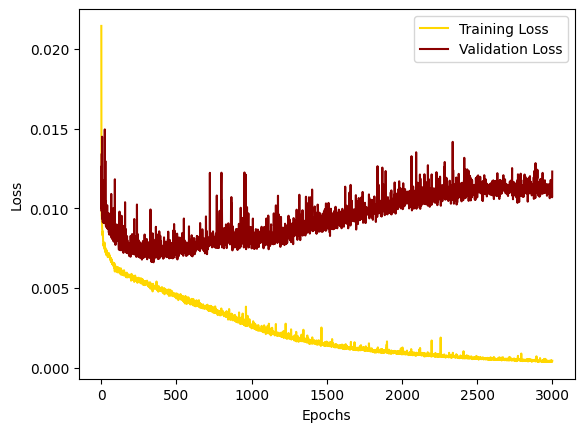

In [58]:
model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="SGD",hidden_layers=3, learningrate=0.1, batch_size=2, n_width=40)
train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=3000)

plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color = "gold")
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color = "darkred")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Second week (on schedule means finish by Wednesday) [if updated: 12-2-2025]
H.	Currently, the model uses a Relu activation function. Test the effect of different activation funtions on the network performance. Show how well does a sigmoid or ELU work (i.e. what is the effect on performance)?

Note, you can either:
- adapt the scripts above to program this "neatly" as input parameter.
- redefine new "programs" below that have the new properties you want.

Note that in the case of option 1, your programs need to stay backwards compatible, as examiners will need to be able to rerun your code and reproduce your results!

The analysis of different activation functions—ReLU, Sigmoid, ELU and Tahn—shows notable differences in network performance. ReLU exhibits instability in training, with significant fluctuations in systematic error and a tendency for higher variance, which could indicate overfitting. Sigmoid, on the other hand, demonstrates better generalization, as seen in the decreasing validation loss over time. However, it is prone to saturation issues, which can slow down convergence. ELU appears to offer the best balance, with smooth convergence, reduced vanishing gradient issues, and a more stable training process compared to ReLU. The systematic error fluctuations in ELU are also less extreme than ReLU, indicating more controlled learning. Tahn, like ELU, offers stable training but may experience saturation at extreme values. Overall, while ReLU remains a strong baseline, Sigmoid may generalize better, Tahn and ELU provides a more stable learning process. 

We observe in the Sigmoid activation function that the validation loss is lower than the training loss, going against our expectations. This could be due to the fact that when computing the losses we devide with the batch size, but maybe the size of the last batch is lower than the specified batch size. So, we end up dividing with a number bigger than the actual size of the last batch resulting in wrongly calculated losses. 

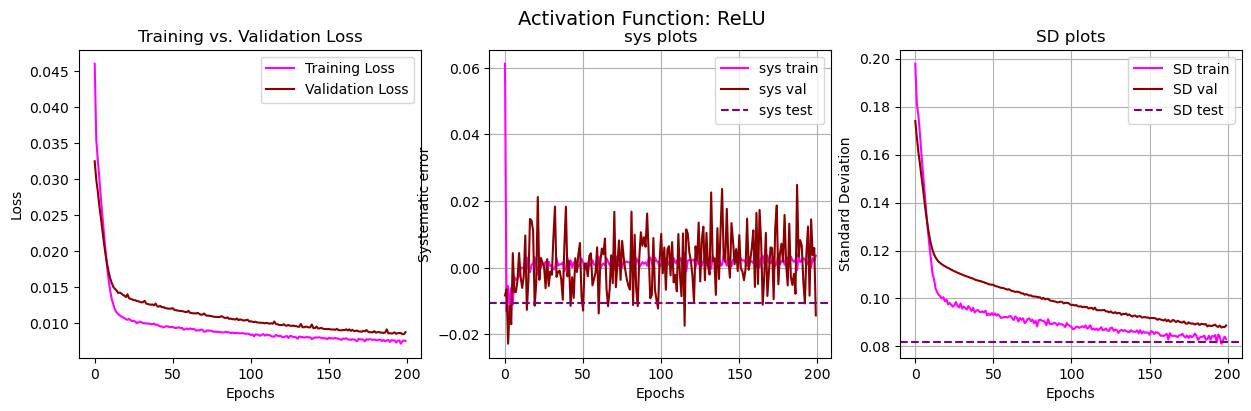

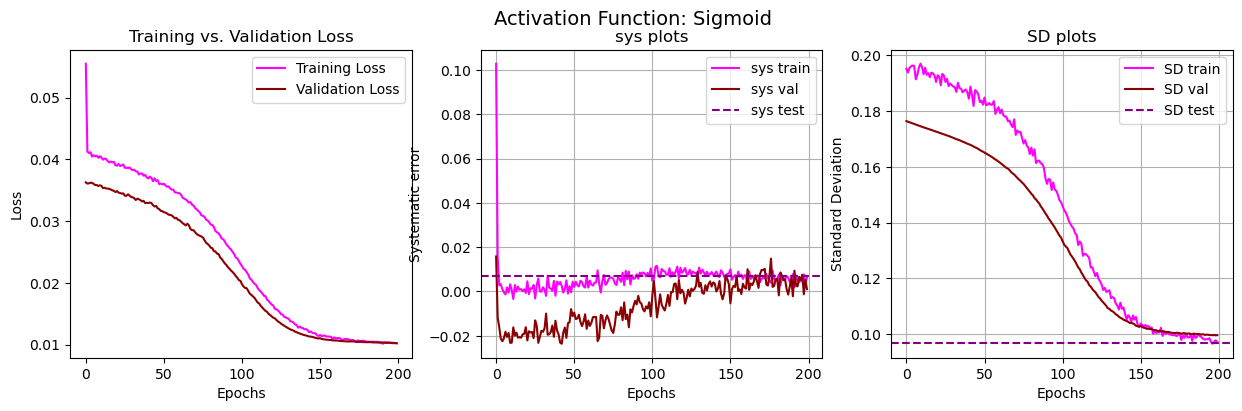

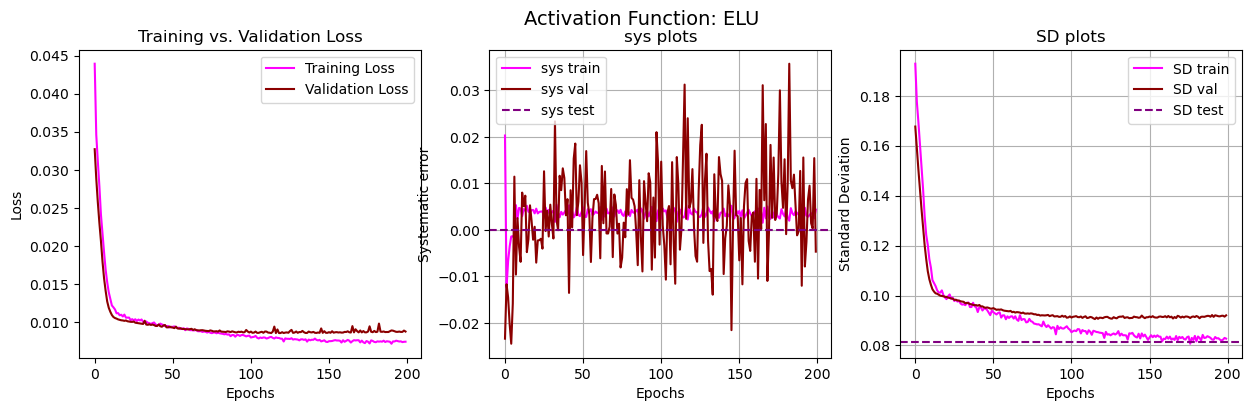

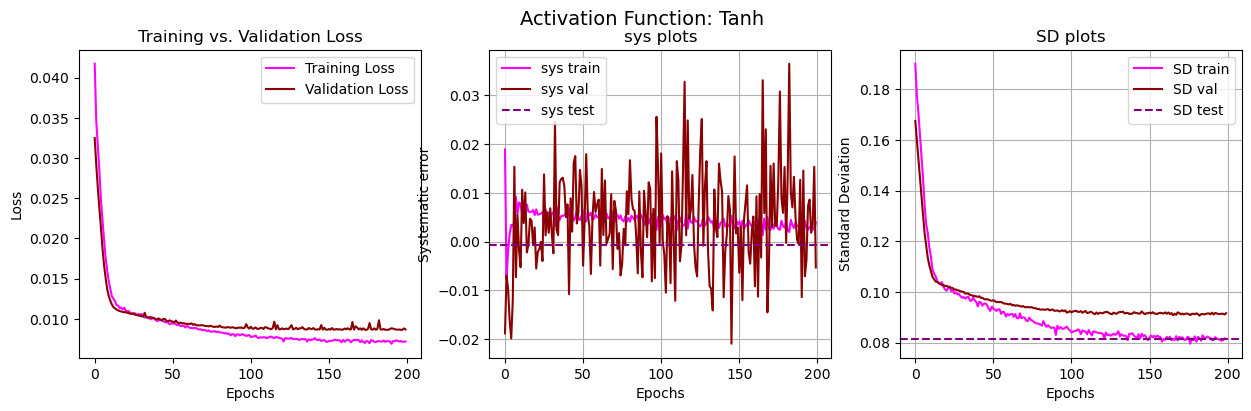

In [70]:
activation_functions = ['ReLU', 'Sigmoid', 'ELU', 'Tanh']
results = {}

for function in activation_functions:
    model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="SGD", learningrate=0.1, function_act=function)
    
    train_losses, val_losses, sys_val, SD_val, sys_train, SD_train = train_val_network(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=200)
    
    f_ref_test, f_pred_test, test_loss_f, SD_test, sys_test = test_network(model, trainloader, inferloader, testloader, device, loss_module)
    
    f_ref_test = torch.cat(f_ref_test).cpu().detach().numpy()
    f_pred_test = torch.cat(f_pred_test).cpu().detach().numpy()

    results[function] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "Final Train Loss": train_losses[-1],
        "Final Validation Loss": val_losses[-1],
        "f_ref_test": f_ref_test,
        "f_pred_test": f_pred_test,
        "Final Test Loss": test_loss_f,
        "sys test": sys_test,
        "SD test": SD_test,
        "sys val": sys_val[-1],
        "SD val": SD_val[-1]
    }

    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    

    # Plot training vs. validation loss
    axes[0].plot(range(len(train_losses)), train_losses, label="Training Loss", color="magenta")
    axes[0].plot(range(len(val_losses)), val_losses, label="Validation Loss", color="darkred")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training vs. Validation Loss")
    axes[0].legend()

    # Plot the results
    axes[1].plot(range(len(train_losses)), sys_train, color="magenta", label="sys train")
    axes[1].plot(range(len(val_losses)), sys_val, color="darkred", label="sys val")
    axes[1].axhline(sys_test, color="purple", label="sys test", linestyle = "--")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Systematic error")
    axes[1].set_title("sys plots")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(range(len(train_losses)), SD_train, color="magenta", label="SD train")
    axes[2].plot(range(len(val_losses)), SD_val, color="darkred", label="SD val")
    axes[2].axhline(SD_test, color="purple", label="SD test", linestyle = "--")
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("Standard Deviation")
    axes[2].set_title("SD plots")
    axes[2].legend()
    axes[2].grid(True)
    fig.suptitle(f"Activation Function: {function}", fontsize=14)    
    plt.show()







So far, we simualted a small amount of data, as it is easier to show overfitting etc. Note that you may want to simulate somewhat more data for this and the following exercises. This can be achieved by setting sims=100000 for the following exercises

I.	Let the network also predict D and Dp (note x[1] and x[3] are D and Dp respectively). Show the loss curve of D and Dp and explain how you can see that they have been implemented properly/the model is learning them.

- The network will need more than 1 output --> tip, use loss_D.backward(retain_graph=True) for the first two losses to remember losses and propogate all 3 losses backward in turn
- Alternatively, you could train 3 networks simultaniously


Note that 0<f<1 on avergae is orders of magnitude larger than D and Dp. To ensure all three losses equally affect the network weights you may want to enlarge the loss of D and Dp by multiplying them with some value.


In [9]:
#function that trains the model and logs the results, including the loss and the error metrics
def train_val_network_mult(model, trainloader, inferloader, testloader, loss_module, device, optimizer, epochs=200, loss_scaleD=100, loss_scaleDp=100):
    
    train_losses_f, train_losses_D, train_losses_Dp = [], [], []
    val_losses_f, val_losses_D, val_losses_Dp = [], [], []
    
    train_sys_errors_f, train_SD_errors_f = [], []
    train_sys_errors_D, train_SD_errors_D = [], []
    train_sys_errors_Dp, train_SD_errors_Dp = [], []
    
    val_sys_errors_f, val_SD_errors_f = [], []
    val_sys_errors_D, val_SD_errors_D = [], []
    val_sys_errors_Dp, val_SD_errors_Dp = [], []

   
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f, train_loss_D, train_loss_Dp = 0, 0, 0
        val_loss_f, val_loss_D, val_loss_Dp = 0, 0, 0
        
        # set model to training mode
        model.train()
        
        #loop over all training data
        SD_train_f, sys_train_f = 0, 0
        SD_train_D, sys_train_D = 0, 0
        SD_train_Dp, sys_train_Dp = 0, 0

        for batch in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data and put on device
            x = batch[0].to(device)
            f_true = torch.flatten(batch[2].to(device))
            D_true = torch.flatten(batch[1].to(device))
            Dp_true = torch.flatten(batch[3].to(device))
            
            # put the data through the neural network
            output = model(x)
            f_pred, D_pred, Dp_pred = output[:, 0], output[:, 1], output[:, 2]
            
            
            #
            loss_f = loss_module(f_pred, f_true) 
            loss_D = loss_module(D_pred, D_true) * loss_scaleD
            loss_Dp = loss_module(Dp_pred, Dp_true) * loss_scaleDp

            loss_f.backward(retain_graph=True)
            loss_D.backward(retain_graph=True) 
            loss_Dp.backward()
            
            optimizer.step()

            train_loss_f += loss_f.item()
            train_loss_D += loss_D.item()
            train_loss_Dp += loss_Dp.item()
            
            # Calculate systematic and standard deviation errors
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_true.cpu().detach().numpy())
            SD_train_f += SD**2
            sys_train_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(), D_true.cpu().detach().numpy())
            SD_train_D += SD**2
            sys_train_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_true.cpu().detach().numpy())
            SD_train_Dp += SD**2
            sys_train_Dp += sys
            
        
        # calculate the mean (sys error) and square of mean (SD).
        SD_train_f, sys_train_f = np.sqrt(SD_train_f / len(trainloader)), sys_train_f / len(trainloader)
        SD_train_D, sys_train_D = np.sqrt(SD_train_D / len(trainloader)), sys_train_D / len(trainloader)
        SD_train_Dp, sys_train_Dp = np.sqrt(SD_train_Dp / len(trainloader)), sys_train_Dp / len(trainloader)

        train_sys_errors_f.append(sys_train_f)
        train_SD_errors_f.append(SD_train_f)
        train_sys_errors_D.append(sys_train_D)
        train_SD_errors_D.append(SD_train_D)
        train_sys_errors_Dp.append(sys_train_Dp)
        train_SD_errors_Dp.append(SD_train_Dp)

        # set model to evaluation mode
        model.eval()
        
        # loop over validation data
        SD_val_f, sys_val_f = 0, 0
        SD_val_D, sys_val_D = 0, 0
        SD_val_Dp, sys_val_Dp = 0, 0
        ######################your code here for validation loss#########################
        for batch in inferloader:
            # get data and put on devide

            x = batch[0].to(device)
            f_true = torch.flatten(batch[2].to(device))
            D_true = torch.flatten(batch[1].to(device))
            Dp_true = torch.flatten(batch[3].to(device))
            
            # put the data through the neural network
            output = model(x)
            f_pred, D_pred, Dp_pred = output[:, 0], output[:, 1], output[:, 2]
            
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_true)
            loss_D = loss_module(D_pred, D_true) * loss_scaleD
            loss_Dp = loss_module(Dp_pred, Dp_true) * loss_scaleDp

            val_loss_f += loss_f.item()
            val_loss_D += loss_D.item()
            val_loss_Dp += loss_Dp.item()
            
            # calculate the standard deviation and systematic error on the validation data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_true.cpu().detach().numpy())
            SD_val_f += SD**2
            sys_val_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(), D_true.cpu().detach().numpy())
            SD_val_D += SD**2
            sys_val_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_true.cpu().detach().numpy())
            SD_val_Dp += SD**2
            sys_val_Dp += sys


        # calculate the mean (sys error) and square of mean (SD).
        SD_val_f, sys_val_f = np.sqrt(SD_val_f / len(inferloader)), sys_val_f / len(inferloader)
        SD_val_D, sys_val_D = np.sqrt(SD_val_D / len(inferloader)), sys_val_D / len(inferloader)
        SD_val_Dp, sys_val_Dp = np.sqrt(SD_val_Dp / len(inferloader)), sys_val_Dp / len(inferloader)

        val_sys_errors_f.append(sys_val_f)
        val_SD_errors_f.append(SD_val_f)
        val_sys_errors_D.append(sys_val_D)
        val_SD_errors_D.append(SD_val_D)
        val_sys_errors_Dp.append(sys_val_Dp)
        val_SD_errors_Dp.append(SD_val_Dp)

        train_losses_f.append(train_loss_f / len(trainloader))
        train_losses_D.append(train_loss_D / len(trainloader))
        train_losses_Dp.append(train_loss_Dp / len(trainloader))
        
        val_losses_f.append(val_loss_f / len(inferloader))
        val_losses_D.append(val_loss_D / len(inferloader))
        val_losses_Dp.append(val_loss_Dp / len(inferloader))

        # Log training and validation loss
        wandb.log({
            "loss/train_f": train_losses_f[-1],
            "loss/val_f": val_losses_f[-1],
            "loss/train_D": train_losses_D[-1],
            "loss/val_D": val_losses_D[-1],
            "loss/train_Dp": train_losses_Dp[-1],
            "loss/val_Dp": val_losses_Dp[-1],
            "error/train_sys_f": sys_train_f,
            "error/train_SD_f": SD_train_f,
            "error/val_sys_f": sys_val_f,
            "error/val_SD_f": SD_val_f
        })

        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data.
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        example_data_val=[[x,y] for (x,y) in zip(f_ref_val.cpu().detach().numpy(),f_pred_val.cpu().detach().numpy())]
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        table_val = wandb.Table(data=example_data_val, columns=["f_ref_val", "f_pred_val"])

        #code from yoad and jonas
        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            if do_D_Dp:
                wandb.log({"loss/train_D": train_loss_D/trainloader.__len__(),"loss/val_D": val_loss_D/inferloader.__len__(),"error/random error_D":SD_train_D,"error/systematic error_D":sys_train_D,"data_plot epoch " + str(epoch) + "_D": wandb.plot.scatter(table_D, "D_ref", "D_pred", title=f'epoch{epoch}')})
                wandb.log({"loss/train_Dp": train_loss_Dp/trainloader.__len__(),"loss/val_Dp": val_loss_Dp/inferloader.__len__(),"error/random error_Dp":SD_train_Dp,"error/systematic error_Dp":sys_train_Dp,"data_plot epoch " + str(epoch) + "_Dp": wandb.plot.scatter(table_Dp, "Dp_ref", "Dp_pred", title=f'epoch{epoch}')})


        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            wandb.log({"data_plot_val epoch " + str(epoch): wandb.plot.scatter(table_val, "f_ref_val", "f_pred_val", title=f'epoch{epoch}')})
        #end of their code
        
        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        example_data_val=[[x,y] for (x,y) in zip(f_ref_val.cpu().detach().numpy(),f_pred_val.cpu().detach().numpy())]
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        table_val = wandb.Table(data=example_data_val, columns=["f_ref_val", "f_pred_val"])

        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            wandb.log({"data_plot_val epoch " + str(epoch): wandb.plot.scatter(table_val, "f_ref_val", "f_pred_val", title=f'epoch{epoch}')})

    return (train_losses_f, val_losses_f, train_losses_D, val_losses_D, train_losses_Dp, val_losses_Dp, 
            val_sys_errors_f, val_SD_errors_f, val_sys_errors_D, val_SD_errors_D, val_sys_errors_Dp, 
            val_SD_errors_Dp, train_sys_errors_f, train_SD_errors_f, train_sys_errors_D, train_SD_errors_D, train_sys_errors_Dp, train_SD_errors_Dp, 
            model)




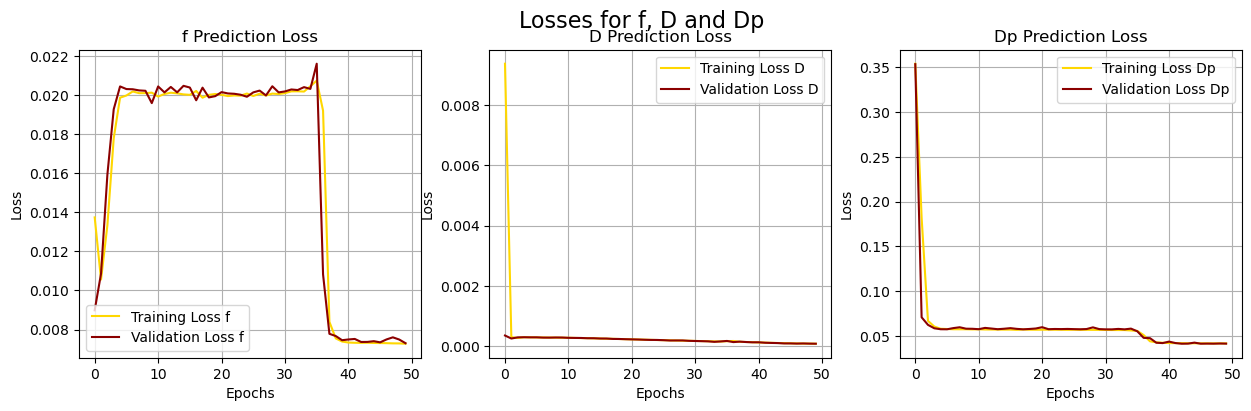

In [11]:
model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="SGD", learningrate=0.1, n_outputs=3, sims=100000)
train_losses_f, val_losses_f, train_losses_D, val_losses_D, train_losses_Dp, val_losses_Dp, val_sys_errors_f, val_SD_errors_f, val_sys_errors_D, val_SD_errors_D, val_sys_errors_Dp, val_SD_errors_Dp, train_sys_errors_f, train_SD_errors_f, train_sys_errors_D, train_SD_errors_D, train_sys_errors_Dp, train_SD_errors_Dp, model = train_val_network_mult(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=50)

fig, axes = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle("Losses for f, D and Dp", fontsize=16)
axes[0].plot(range(len(train_losses_f)), train_losses_f, label="Training Loss f", color="gold")
axes[0].plot(range(len(val_losses_f)), val_losses_f, label="Validation Loss f", color="darkred")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)
axes[0].set_title("f Prediction Loss")

axes[1].plot(range(len(train_losses_D)), train_losses_D, label="Training Loss D", color="gold")
axes[1].plot(range(len(val_losses_D)), val_losses_D, label="Validation Loss D", color="darkred")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)
axes[1].set_title("D Prediction Loss")

axes[2].plot(range(len(train_losses_Dp)), train_losses_Dp, label="Training Loss Dp", color="gold")
axes[2].plot(range(len(val_losses_Dp)), val_losses_Dp, label="Validation Loss Dp", color="darkred")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)
axes[2].set_title("Dp Prediction Loss")
plt.show()



J.	Use the sigmoid in the final layer to constrain 0.5e-3 <D< 3.5e-3; 0<f<1; 5e-3<D*<130e-3. Explain how you did this.


Note: D, f and D* are in very different parameter value ranges, and hence their RMS is too. A network will focus on the largest loss. You may want to scale the RMS to similar ranges for the network to consider all 3 parameters during optmizing. 

Also note: You may want to play with hyperparameters.

Explanation for J <br>
The CustomOutputLayer class applies a sigmoid activation function to the outputs, constraining them within the range of [0, 1]. Then, each output is scaled linearly to match the desired target ranges: <br>
The first output,  f , is already constrained to the range [0, 1] by the sigmoid function. <br>
The second output,  D , is scaled from the sigmoid range [0, 1] to the range [0.5e-3, 3.5e-3] using a linear transformation. <br>
The third output,  D^* , is scaled from [0, 1] to [5e-3, 130e-3], again using a linear transformation.

Based on the results we got from the analysis done in the previous questions, we chose Adagrad as the optimizer, ELU as the activation function, 5 hidden layers and 16 as the batch size. 

In [226]:
#function that trains the model and logs the results, including the loss and the error metrics
def train_val_network_mult_j(model, trainloader, inferloader, testloader, loss_module, device, optimizer, epochs=200):
    
    train_losses_f, train_losses_D, train_losses_Dp = [], [], []
    train_total_loss = []
    val_losses_f, val_losses_D, val_losses_Dp = [], [], []
    val_total_loss = []
    
    train_sys_errors_f, train_SD_errors_f = [], []
    train_sys_errors_D, train_SD_errors_D = [], []
    train_sys_errors_Dp, train_SD_errors_Dp = [], []
    
    val_sys_errors_f, val_SD_errors_f = [], []
    val_sys_errors_D, val_SD_errors_D = [], []
    val_sys_errors_Dp, val_SD_errors_Dp = [], []

   
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f, train_loss_D, train_loss_Dp = 0, 0, 0
        val_loss_f, val_loss_D, val_loss_Dp = 0, 0, 0
        
        # set model to training mode
        model.train()
        
        #loop over all training data
        SD_train_f, sys_train_f = 0, 0
        SD_train_D, sys_train_D = 0, 0
        SD_train_Dp, sys_train_Dp = 0, 0

        for batch in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data and put on device
            x = batch[0].to(device)
            f_true = torch.flatten(batch[2].to(device))
            D_true = torch.flatten(batch[1].to(device))
            Dp_true = torch.flatten(batch[3].to(device))
            
            # put the data through the neural network
            output = model(x)
            f_pred, D_pred, Dp_pred = output[:, 0], output[:, 1], output[:, 2]
            
            RMSE_f = torch.sqrt(loss_module(f_pred, f_true)) + 1e-6
            RMSE_D = torch.sqrt(loss_module(D_pred, D_true)) + 1e-6
            RMSE_Dp = torch.sqrt(loss_module(Dp_pred, Dp_true)) + 1e-6
            #
            
            loss_f = loss_module(f_pred, f_true) / RMSE_f
            loss_D = loss_module(D_pred, D_true) / RMSE_D 
            loss_Dp = loss_module(Dp_pred, Dp_true) / RMSE_Dp

            total_loss = loss_f + loss_D + loss_Dp
            total_loss.backward()

            
            optimizer.step()

            train_loss_f += loss_f.item()
            train_loss_D += loss_D.item()
            train_loss_Dp += loss_Dp.item()
            
            # Calculate systematic and standard deviation erros
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_true.cpu().detach().numpy())
            SD_train_f += SD**2
            sys_train_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(), D_true.cpu().detach().numpy())
            SD_train_D += SD**2
            sys_train_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_true.cpu().detach().numpy())
            SD_train_Dp += SD**2
            sys_train_Dp += sys
            
        
        # calculate the mean (sys error) and square of mean (SD).
        SD_train_f, sys_train_f = np.sqrt(SD_train_f / len(trainloader)), sys_train_f / len(trainloader)
        SD_train_D, sys_train_D = np.sqrt(SD_train_D / len(trainloader)), sys_train_D / len(trainloader)
        SD_train_Dp, sys_train_Dp = np.sqrt(SD_train_Dp / len(trainloader)), sys_train_Dp / len(trainloader)

        train_sys_errors_f.append(sys_train_f)
        train_SD_errors_f.append(SD_train_f)
        train_sys_errors_D.append(sys_train_D)
        train_SD_errors_D.append(SD_train_D)
        train_sys_errors_Dp.append(sys_train_Dp)
        train_SD_errors_Dp.append(SD_train_Dp)
        train_total_loss.append(total_loss.item())

        # set model to evaluation mode
        model.eval()
        
        # loop over validation data
        SD_val_f, sys_val_f = 0, 0
        SD_val_D, sys_val_D = 0, 0
        SD_val_Dp, sys_val_Dp = 0, 0
        ######################your code here for validation loss#########################
        for batch in inferloader:
            # get data and put on devide
            x = batch[0].to(device)
            f_true = torch.flatten(batch[2].to(device))
            D_true = torch.flatten(batch[1].to(device))
            Dp_true = torch.flatten(batch[3].to(device))
            
            # put the data through the neural network
            output = model(x)
            f_pred, D_pred, Dp_pred = output[:, 0], output[:, 1], output[:, 2]
            
            # calculate loss (compare predicted f to the ground trueth)
            RMSE_f = torch.sqrt(loss_module(f_pred, f_true)) + 1e-6
            RMSE_D = torch.sqrt(loss_module(D_pred, D_true)) + 1e-6
            RMSE_Dp = torch.sqrt(loss_module(Dp_pred, Dp_true)) + 1e-6
            #
            
            loss_f = loss_module(f_pred, f_true) / RMSE_f
            loss_D = loss_module(D_pred, D_true) / RMSE_D 
            loss_Dp = loss_module(Dp_pred, Dp_true) / RMSE_Dp

            total_loss = loss_f + loss_D + loss_Dp
            total_loss.backward()

            val_loss_f += loss_f.item()
            val_loss_D += loss_D.item()
            val_loss_Dp += loss_Dp.item()
            
            # calculate the standard deviation and systematic error on the validation data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_true.cpu().detach().numpy())
            SD_val_f += SD**2
            sys_val_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(), D_true.cpu().detach().numpy())
            SD_val_D += SD**2
            sys_val_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_true.cpu().detach().numpy())
            SD_val_Dp += SD**2
            sys_val_Dp += sys


        # calculate the mean (sys error) and square of mean (SD).
        SD_val_f, sys_val_f = np.sqrt(SD_val_f / len(inferloader)), sys_val_f / len(inferloader)
        SD_val_D, sys_val_D = np.sqrt(SD_val_D / len(inferloader)), sys_val_D / len(inferloader)
        SD_val_Dp, sys_val_Dp = np.sqrt(SD_val_Dp / len(inferloader)), sys_val_Dp / len(inferloader)

        val_sys_errors_f.append(sys_val_f)
        val_SD_errors_f.append(SD_val_f)
        val_sys_errors_D.append(sys_val_D)
        val_SD_errors_D.append(SD_val_D)
        val_sys_errors_Dp.append(sys_val_Dp)
        val_SD_errors_Dp.append(SD_val_Dp)

        train_losses_f.append(train_loss_f / len(trainloader))
        train_losses_D.append(train_loss_D / len(trainloader))
        train_losses_Dp.append(train_loss_Dp / len(trainloader))
        
        val_losses_f.append(val_loss_f / len(inferloader))
        val_losses_D.append(val_loss_D / len(inferloader))
        val_losses_Dp.append(val_loss_Dp / len(inferloader))
        val_total_loss.append(total_loss.item())

        # Log training and validation loss
        wandb.log({
            "loss/train_f": train_losses_f[-1],
            "loss/val_f": val_losses_f[-1],
            "loss/train_D": train_losses_D[-1],
            "loss/val_D": val_losses_D[-1],
            "loss/train_Dp": train_losses_Dp[-1],
            "loss/val_Dp": val_losses_Dp[-1],
            "error/train_sys_f": sys_train_f,
            "error/train_SD_f": SD_train_f,
            "error/val_sys_f": sys_val_f,
            "error/val_SD_f": SD_val_f
        })

        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data.
        """example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        example_data_val=[[x,y] for (x,y) in zip(f_ref_val.cpu().detach().numpy(),f_pred_val.cpu().detach().numpy())]
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        table_val = wandb.Table(data=example_data_val, columns=["f_ref_val", "f_pred_val"])

        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            wandb.log({"data_plot_val epoch " + str(epoch): wandb.plot.scatter(table_val, "f_ref_val", "f_pred_val", title=f'epoch{epoch}')})
        
        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        example_data_val=[[x,y] for (x,y) in zip(f_ref_val.cpu().detach().numpy(),f_pred_val.cpu().detach().numpy())]
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        table_val = wandb.Table(data=example_data_val, columns=["f_ref_val", "f_pred_val"])

        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            wandb.log({"data_plot_val epoch " + str(epoch): wandb.plot.scatter(table_val, "f_ref_val", "f_pred_val", title=f'epoch{epoch}')})"""

    return (train_losses_f, val_losses_f, train_losses_D, val_losses_D, train_losses_Dp, val_losses_Dp, 
            val_sys_errors_f, val_SD_errors_f, val_sys_errors_D, val_SD_errors_D, val_sys_errors_Dp, 
            val_SD_errors_Dp, train_sys_errors_f, train_SD_errors_f, train_sys_errors_D, train_SD_errors_D, train_sys_errors_Dp, train_SD_errors_Dp, 
            train_total_loss, val_total_loss, model)




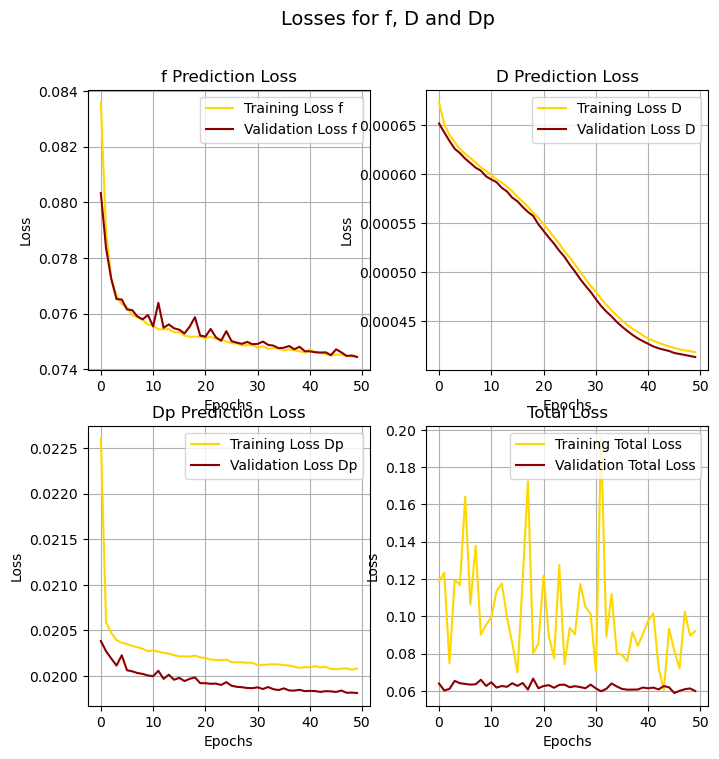

In [233]:

# Assume we have data loaders, optimizer, etc.
model, trainloader, inferloader, testloader, loss_module, device, opt = create_data_model('test', optimizer="Adagrad", learningrate=0.01, n_outputs=3, sims=100000, custom_output=1, function_act="ELU", hidden_layers=5)
train_losses_f, val_losses_f, train_losses_D, val_losses_D, train_losses_Dp, val_losses_Dp, val_sys_errors_f, val_SD_errors_f, val_sys_errors_D, val_SD_errors_D, val_sys_errors_Dp, val_SD_errors_Dp, train_sys_errors_f, train_SD_errors_f, train_sys_errors_D, train_SD_errors_D, train_sys_errors_Dp, train_SD_errors_Dp, train_total_loss, val_total_loss, trained_model = train_val_network_mult_j(model, trainloader, inferloader, testloader, loss_module, device, opt, epochs=50)

# Plotting the losses
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Losses for f, D and Dp", fontsize=14)

axes[0, 0].plot(range(len(train_losses_f)), train_losses_f, label="Training Loss f", color="gold")
axes[0, 0].plot(range(len(val_losses_f)), val_losses_f, label="Validation Loss f", color="darkred")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_title("f Prediction Loss")

axes[0, 1].plot(range(len(train_losses_D)), train_losses_D, label="Training Loss D", color="gold")
axes[0, 1].plot(range(len(val_losses_D)), val_losses_D, label="Validation Loss D", color="darkred")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_title("D Prediction Loss")

axes[1, 0].plot(range(len(train_losses_Dp)), train_losses_Dp, label="Training Loss Dp", color="gold")
axes[1, 0].plot(range(len(val_losses_Dp)), val_losses_Dp, label="Validation Loss Dp", color="darkred")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].set_title("Dp Prediction Loss")

axes[1, 1].plot(range(len(train_total_loss)), train_total_loss, label="Training Total Loss", color="gold")
axes[1, 1].plot(range(len(val_total_loss)), val_total_loss, label="Validation Total Loss", color="darkred")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].set_title("Total Loss")


plt.show()

# For scoring 7.5+
So far, you have been working with simulated data (taken care of by Data_loader.py). For such data, we know the ground truth values. However, in vivo, we have no way of knowing the ground truth. How will our network perform? Note that for this exercise you may need ot play with hyperparameters and design choices to train.

K.	Use the network, as trained in (J) and apply it to real-world data which is provided by running “dataval, valid_id, bvalues = hf.load_real_data(eval=True)”.
- You will need to export you trained network in the return of the "train_network" function
- you will need to apply it to the "dataval" from hf.load_real_data(eval=True)
- you will then want to put the outputs through "hf.plot_example(np.squeeze(D_out), valid_id,0.003)", "hf.plot_example(np.squeeze(f_out), valid_id,0.7)" and "hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)", with the predicted D, f and Dp being D_out, f_out and Dp_out.

Note that alongside your plot (the first), also a conventional least squares fit is provided as a reference. Show the resulting parameter maps. How does your approach compare? Why do you think your particular approach would look better/worse?




Load patient data 

Patient data loaded

Load patient data 

Patient data loaded

training data is 103608 long
Load patient data 



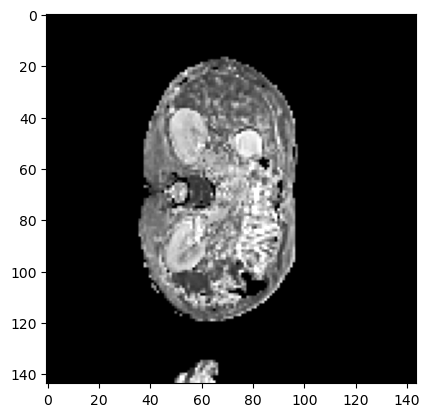

Load patient data 



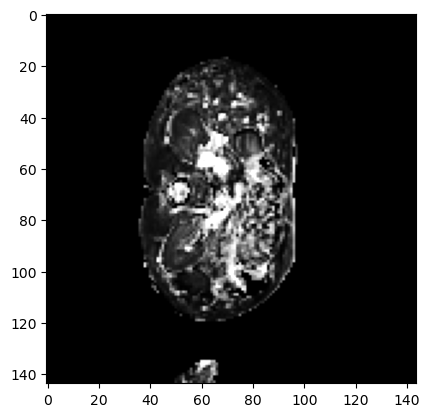

Load patient data 



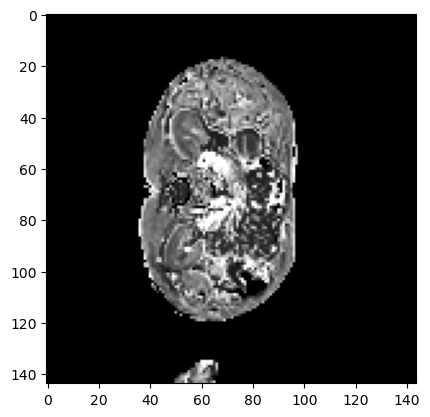

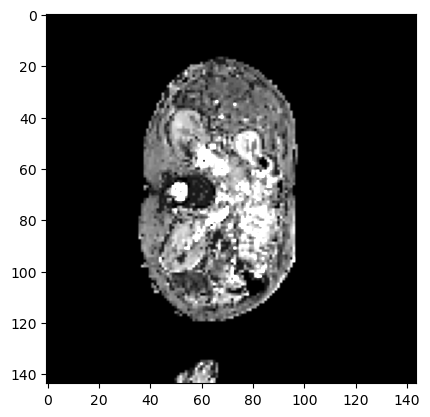

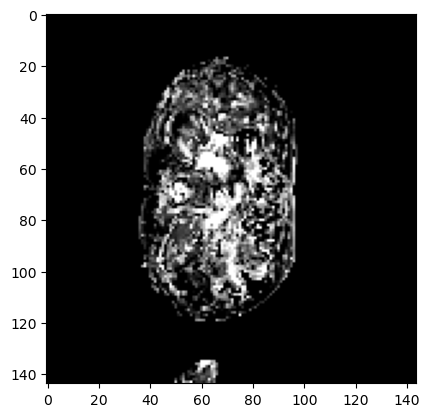

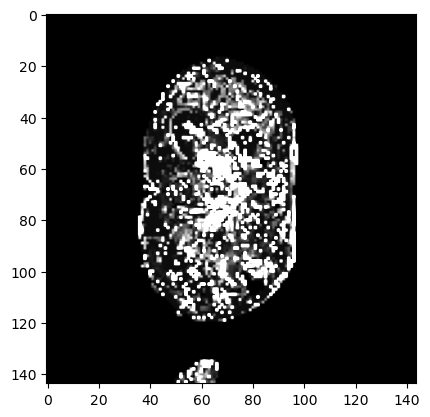

In [234]:
datatrain, bvalues = hf.load_real_data(eval=False)
dataval, valid_id, bvalues = hf.load_real_data(eval=True)
print('training data is ' + str(len(datatrain)) + ' long')

''''your code here'''
### use datatrain to train your network.
trained_model.eval()

f_out = []
D_out = []
Dp_out = []
f_ref_val = []
D_ref_val = []
Dp_ref_val = []

## then test your network using dataval.
for batch in dataval:
    x = torch.tensor(batch[:12], dtype=torch.float32, device=device).view(1, 12).to(device)  # Ensure correct shape
    f_true = torch.tensor(batch[2], dtype=torch.float32, device=device).flatten()
    D_true = torch.tensor(batch[1], dtype=torch.float32, device=device).flatten()
    Dp_true = torch.tensor(batch[3], dtype=torch.float32, device=device).flatten()

    # Perform inference without gradient calculation
    if x.dim() == 1:  # If x is 1D, reshape it to 2D
        x = x.view(1, -1)
    with torch.no_grad():
        outputs = trained_model(x)
        f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]
    
    # Store predictions and ground truth values
        f_out.append(f_pred)
        D_out.append(D_pred)
        Dp_out.append(Dp_pred)
        f_ref_val.append(f_true)
        D_ref_val.append(D_true)
        Dp_ref_val.append(Dp_true)


''''if you manage to make predictions of D, f and Dp, the following code will allow you to plot them:'''

hf.plot_example(np.squeeze(D_out), valid_id,0.003)
hf.plot_example(np.squeeze(f_out), valid_id,0.7)
hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)
hf.plot_ref()

L.	Ideally, you would train your network on real-world data. However, in this particular case, it is hard to get gold standard references. Luckily, we can use our understanding of physics, and of how stuff “should behave” to work our way around this. You will redesign your network loss, such that it can train on data without any gold standard references! Instead of placing the L2 loss on f_pred v.s. f_ref. Currently, the network is learning to minimize the difference between predicted fpred and the ground truth referene ftrue. In vivo, we may not have these references. To overcome this, we will now introduce a physics-informed loss. Use the IVIM equation [1] to propogate the predictions (D, f and Dp) into the signal space (S). Then, take e.g. the mean-square-error between the predicted signal and the input signal. Note that you will need to use torch functions (instead of numpy functions) to ensure you can backpropogate the loss through the equation into the network. You can train this network on the simulated data from earlier exercises. But it should also be able to train it on the in vivo data from "datatrain, bvalues = hf.load_real_data(eval=False)". This ensures that the network is use to looking at "real" data. Optimize the network’s training using the real data provided (“test_in_vivo.py”; datatrain). Evaluate the network on the same data as in 1 (data, valid_id, bvalues = dl.load_real_data(eval=True)). How does it perform?

In [ ]:
datatrain, bvalues = hf.load_real_data(eval=False)
dataval, valid_id, bvalues = hf.load_real_data(eval=True)
print('training data is ' + str(len(datatrain)) + ' long')

''''your code here'''
### use datatrain to train your network.
model, train_losses_f, train_losses_D, train_losses_Dp, train_sys_errors_f, train_SD_errors_f, train_sys_errors_D, train_SD_errors_D, train_sys_errors_Dp, train_SD_errors_Dp = train_return_network('test', datatrain, custom_loss, device)
model.eval()

f_out = []
D_out = []
Dp_out = []
f_ref_val = []
D_ref_val = []
Dp_ref_val = []

## then test your network using dataval.
for batch in dataval:
    x, f_true, D_true, Dp_true = batch[0], batch[1], batch[2], batch[3]
    x, f_true, D_true, Dp_true = x.to(device), f_true.to(device), D_true.to(device), Dp_true.to(device)

    # Perform inference without gradient calculation
    with torch.no_grad():
        outputs = model(x)
        f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        
        # Store predictions and ground truth values
        f_out.append(f_pred)
        D_out.append(D_pred)
        Dp_out.append(Dp_pred)
        f_ref_val.append(f_true)
        D_ref_val.append(D_true)
        Dp_ref_val.append(Dp_true)


''''if you manage to make predictions of D, f and Dp, the following code will allow you to plot them:'''

hf.plot_example(np.squeeze(D_out), valid_id,0.003)
hf.plot_example(np.squeeze(f_out), valid_id,0.7)
hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)
hf.plot_ref()

### you can compare supervised and self-supervised fits